<a href="https://colab.research.google.com/github/alaeddinehamroun/Natural-Language-Processing/blob/main/NLP_Vector_Space_Models_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the real world, you can always load the trained word vectors, and you will almost never have to train them from scratch.

##1 Predict the Countries from Capitals


### 1.1 Importing the data

In [4]:
# Run this cell to import packages.
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        fr_embeddings:
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
        
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [6]:
import io
import requests
url="https://raw.githubusercontent.com/amanjeetsahu/Natural-Language-Processing-Specialization/master/Natural%20Language%20Processing%20with%20Classification%20and%20Vector%20Spaces/Week%203/capitals.txt"
s=requests.get(url).content


In [7]:
data = pd.read_csv(io.StringIO(s.decode('utf-8')), delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


Note that because the original google news word embedding dataset is about 3.64 gigabytes, the workspace is not able to handle the full file set. So we've downloaded the full dataset, extracted a sample of the words that we're going to analyze in this assignment, and saved it in a pickle file called word_embeddings_capitals.p

In [8]:
import nltk
from gensim.models import KeyedVectors

In [ ]:
embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)
f = open('capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)

def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings


# Testing your function
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "word_embeddings_subset.p", "wb" ) )

In [11]:
word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))
len(word_embeddings)  # there should be 243 words that will be used in this assignment

243

In [15]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


#### Predict relationships among words

* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to __"?
* You will write a program that is capable of finding the fourth word.
* We will give you a hint to show you how to compute this.


### 1.2 Cosine Similarity

In [12]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)
    return cos

In [13]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

### 1.3 Euclidean distance

In [14]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """

    # euclidean distance

    d = np.linalg.norm(A-B)

    return d

In [15]:
euclidean(king, queen)

2.4796925

### 1.4 Finding the country of each capital

In [16]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """

    # store the city1, country 1, and city 2 in a set called group
    group = set((city1, country1, city2))

    # get embeddings of city 1
    city1_emb = word_embeddings[city1]

    # get embedding of country 1
    country1_emb = word_embeddings[country1]

    # get embedding of city 2
    city2_emb = word_embeddings[city2]

    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = Queen
    vec = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1

    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # first check that the word is not already in the 'group'
        if word not in group:

            # get the word embedding
            word_emb = word_embeddings[word]

            # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            cur_similarity = cosine_similarity(vec,word_emb)

            # if the cosine similarity is more similar than the previously best similarity...
            if cur_similarity > similarity:

                # update the similarity to the new, better similarity
                similarity = cur_similarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)
    return country

In [17]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

### 1.5 Model Accuracy

In [18]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''

    # initialize num correct to zero
    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():

        # get city1
        city1 = row['city1']

        # get country1
        country1 = row['country1']

        # get city2
        city2 =  row['city2']

        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1,country1,city2,word_embeddings)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct by 1
            num_correct += 1

    # get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct/m

    return accuracy

In [19]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


##2 Plotting the vectors using PCA

 As we saw, we are working in a 300-dimensional space in this case. Although from a computational perspective we were able to perform a good job, it is impossible to visualize results in such high dimensional spaces.


 You can think of PCA as a method that projects our vectors in a space of reduced dimension, while keeping the maximum information about the original vectors in their reduced counterparts. In this case, by maximum infomation we mean that the Euclidean distance between the original vectors and their projected siblings is minimal. Hence vectors that were originally close in the embeddings dictionary, will produce lower dimensional vectors that are still close to each other.

The steps to compute PCA are as follows:


1. Mean normalize the data
2. Compute the covariance matrix of your data
3. Compute the eigenvectors and the eigenvalues of your covariance matrix

4. Multiply the first K eigenvectors by your normalized data. 


In [20]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    """

    # mean center the data
    X_demeaned = X - np.mean(X,axis=0)

    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    return X_reduced

In [21]:
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [22]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


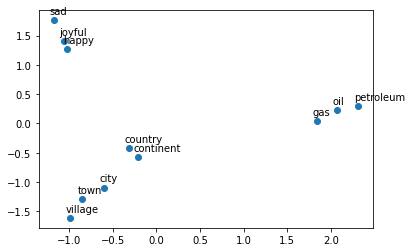

In [23]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

The word vectors for 'gas', 'oil' and 'petroleum' appear related to each other, because their vectors are close to each other. Similarly, 'sad', 'joyful' and 'happy' all express emotions, and are also near each other.